
### Part 3:

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice).
What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

In [37]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats, integrate
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [38]:

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
sns.set(rc={"figure.figsize": (18, 6), 'legend.fontsize': 18})

In [39]:
#Load json info
with open('ultimate_data_challenge.json') as f:
    df = json.load(f)

#Convert to dataframe
df= pd.DataFrame(df)

#Convert the time series to datetimes appropriately
df["signup_date_1"]= pd.to_datetime(df.signup_date)
df["last_trip_date_1"] = pd.to_datetime(df.last_trip_date)

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,signup_date_1,last_trip_date_1
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,2014-01-25,2014-06-17
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,2014-01-29,2014-05-05
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,2014-01-06,2014-01-07
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,2014-01-10,2014-06-29
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,2014-01-27,2014-03-15


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
signup_date_1             50000 non-null datetime64[ns]
last_trip_date_1          50000 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(4)
memory usage: 5.0+ MB


From above we can see that we have
1.  6 numeric( floating point) variables ( avg_dist, avg_rating_by_driver, avg_rating_of_driver, avg_surge, surge_pct,trips_in_first_30_Days and weekday_pct).
2.  3 categorical features: city , phone, ultimate_black_user.
3.  2 datetime features last_trip_date and trips_in_first_30_days. These two can be used to figure out the response if the rider was active in the last month before the 6th month after signup.
                            

In [41]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [42]:
df[['signup_date', 'last_trip_date']].describe()

,signup_date,last_trip_date
count,50000,50000
unique,31,182
top,2014-01-18,2014-06-29
freq,2948,2036


### Create Response Variable Active_Status:
The data are from a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; a user  is considered to be retained if they were “active” (i.e. took a trip) in the preceding 30 days.

All users who were active within 30 days prior to the date the data was pulled would be considered active and those who were not 
would be considered non active. The variable last_trip_date could be used to determine this. 
We first need to get the latest date for this variable. We would consider this data to be the date when the data was pulled. 
All users whose last_trip_date falls within 30 days of this date would be considered active indicated by a 1 and 0 otherwise.

In [43]:
df['last_trip_date_1'].max()


Timestamp('2014-07-01 00:00:00')

In [44]:

active_status = []
for i in range(len(df)):
   
    end_date = pd.Timestamp(df['last_trip_date_1'].max())
    
    prior_30 = end_date - pd.Timedelta('30D') #set point 30 days prior
    
    if prior_30 <= pd.Timestamp(df['last_trip_date_1'][i]) <= end_date:
        active_status.append(1) # If active, set active_status to 1
    else:
        active_status.append(0)
df["active_status"] =active_status

In [45]:
df[['signup_date', 'last_trip_date_1', "active_status"]].head(20)

,signup_date,last_trip_date_1,active_status
0,2014-01-25,2014-06-17,1
1,2014-01-29,2014-05-05,0
2,2014-01-06,2014-01-07,0
3,2014-01-10,2014-06-29,1
4,2014-01-27,2014-03-15,0
5,2014-01-09,2014-06-06,1
6,2014-01-24,2014-01-25,0
7,2014-01-28,2014-01-29,0
8,2014-01-21,2014-02-01,0
9,2014-01-03,2014-01-05,0


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
signup_date_1             50000 non-null datetime64[ns]
last_trip_date_1          50000 non-null datetime64[ns]
active_status             50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(4)
memory usage: 5.4+ MB


In [47]:
df.drop(["signup_date_1", "last_trip_date_1",  "signup_date", "last_trip_date"], axis=1, inplace=True)

In [48]:
# number of missing values
print('numberof missing values for avg_rating_by_driver: {}'.format(50000-49799))
print('numberof missing values for avg_rating__of_driver: {}'.format(50000-41878))
print('numberof missing values for phone: {}'.format(50000-49604))

numberof missing values for avg_rating_by_driver: 201
numberof missing values for avg_rating__of_driver: 8122
numberof missing values for phone: 396


### Missing Values: 
There are missing values for avg_rating_by driver, avg_rating_of_driver and phone as the number of entries is 
less than 50000.
The number of missing values for phones is very small and those rows with missing phone could be dropped. The average ratings though may be important and some thought should be put into handling these values. 



In [49]:
df["avg_rating_by_driver"].unique()

array([5. , 4.9, 4. , 3. , 4.8, 4.7, 4.5, 4.2, nan, 4.4, 4.6, 3.7, 4.3,
       3.5, 2. , 3.8, 2.5, 4.1, 3.9, 1. , 3.3, 3.4, 3.6, 3.2, 2.3, 2.8,
       1.5, 2.7])

In [50]:
df["avg_rating_of_driver"].unique()

array([4.7, 5. , 4.3, 4.6, 4.4, 3.5, nan, 4.5, 4. , 3.9, 4.9, 4.8, 2.5,
       3.7, 1. , 4.1, 4.2, 3. , 3.8, 2. , 2.7, 3.3, 2.8, 3.6, 3.4, 3.2,
       2.6, 3.1, 2.9, 1.7, 1.8, 1.5, 2.3, 1.9, 2.1, 2.4, 1.6, 2.2])

For both the ratings we will bin them into categories None ,0-1, 1-2, 2-3, 3-4, 4-5, where 0 would be the category with missing ratings.

In [51]:
df["avg_rating_by_driver"]=df["avg_rating_by_driver"].fillna(-1) #replace NAN as -1
df["avg_rating_of_driver"]=df["avg_rating_of_driver"].fillna(-1) #replace NAN as -1


bins = [-2, 0, 1.1, 2.1,  3.1, 4.1 ,5.1]

group_names = ['None', '0-1', '1-2', '2-3', '3-4', '4-5']

df['avg_rating_by_driver_grouped'] = pd.cut(df["avg_rating_by_driver"], bins, labels=group_names)
df['avg_rating_of_driver_grouped'] = pd.cut(df["avg_rating_of_driver"], bins, labels=group_names)

In [52]:
df[['avg_rating_by_driver_grouped']].head()

,avg_rating_by_driver_grouped
0,4-5
1,4-5
2,4-5
3,4-5
4,4-5


In [53]:
df[['avg_rating_of_driver_grouped']].tail()

,avg_rating_of_driver_grouped
49995,4-5
49996,None
49997,4-5
49998,2-3
49999,None


In [54]:
#drop the original columns
df.drop(["avg_rating_by_driver", "avg_rating_of_driver" ], axis=1, inplace=True)

Next we will consider how to deal with the missing phone information.

In [55]:
df["phone"].unique()

array(['iPhone', 'Android', None], dtype=object)

In [56]:
#how many have missing values.
df['phone'].isnull().sum()

396

Create a category "Missing" for those users with missing entries for "phone".

In [57]:
df['phone']=df['phone'].fillna('Missing')

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                        50000 non-null float64
avg_surge                       50000 non-null float64
city                            50000 non-null object
phone                           50000 non-null object
surge_pct                       50000 non-null float64
trips_in_first_30_days          50000 non-null int64
ultimate_black_user             50000 non-null bool
weekday_pct                     50000 non-null float64
active_status                   50000 non-null int64
avg_rating_by_driver_grouped    50000 non-null category
avg_rating_of_driver_grouped    50000 non-null category
dtypes: bool(1), category(2), float64(4), int64(2), object(2)
memory usage: 3.2+ MB



Take a look at the other features. What is their range of distribution? 

#### Continous Features:

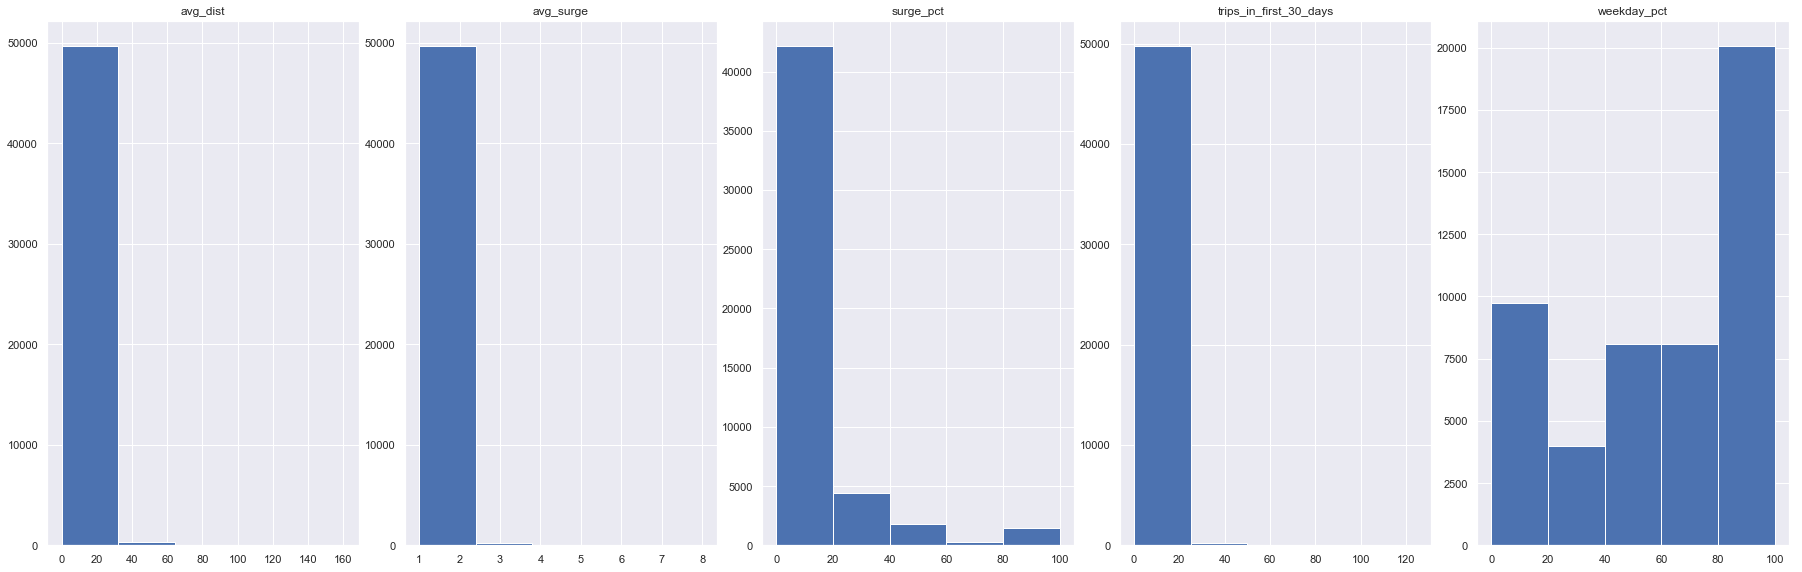

In [59]:
plt.rcParams["figure.figsize"] =(25,8)

continous = ["avg_dist",  "avg_surge", 
             "surge_pct", "trips_in_first_30_days", "weekday_pct"]


f, axes = plt.subplots(1, 5) 
f.tight_layout()
axes=axes.ravel()

for i, var in enumerate(continous):

    axes[i].hist(df[var].dropna(), bins=5)
    axes[i].set_title(var)
    



For the Features that have a high frequency in the low values, replot by specifying bin width to take a look at the distribution 
of the feature values. 

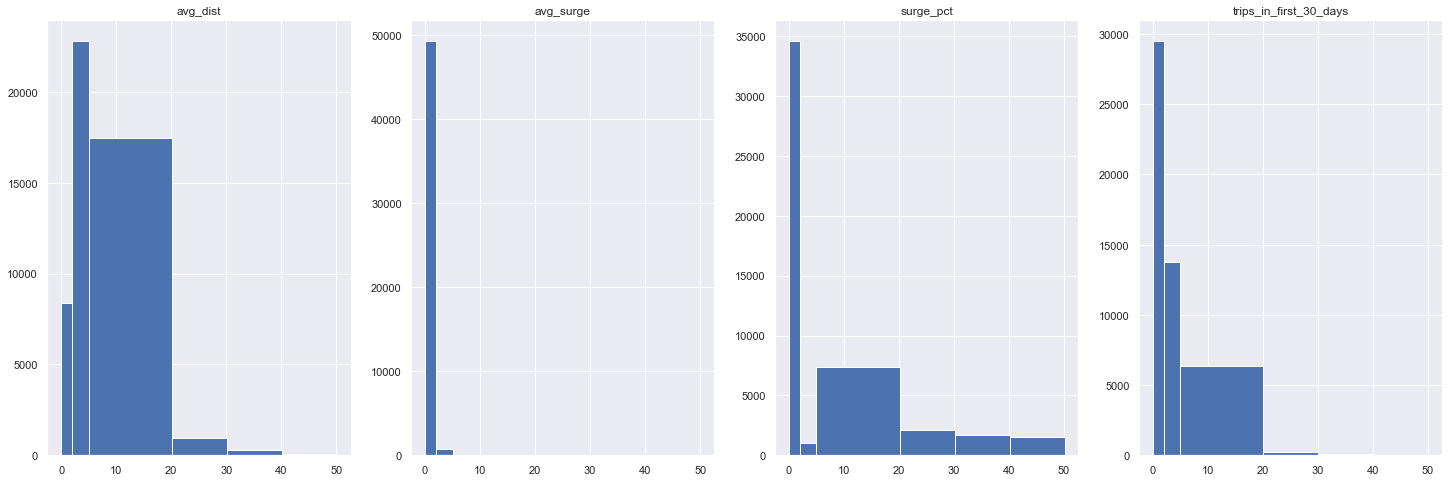

In [60]:
continous_50 = ["avg_dist",  "avg_surge", 
             "surge_pct", "trips_in_first_30_days"]

bins = [0, 2, 5, 20.1, 30.1, 40.1, 50.1]
 
f, axes = plt.subplots(1, 4) 
axes=axes.ravel()
for i, var in enumerate(continous_50):

    axes[i].hist(df[var].dropna(), bins=bins)
    axes[i].set_title(var)
    
plt.show()


#### Categorical Features:

In [61]:
# look at the number of unique categories for each categorical feature
for col_name in df.columns:
    if df[col_name].dtypes in['object', 'bool']:
        unique_cat = len(df[col_name].unique())
        print(" '{col_name}' : {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
        

 'city' : 3 unique categories
 'phone' : 3 unique categories
 'ultimate_black_user' : 2 unique categories


 ##### What fraction of the observed users were retained? 

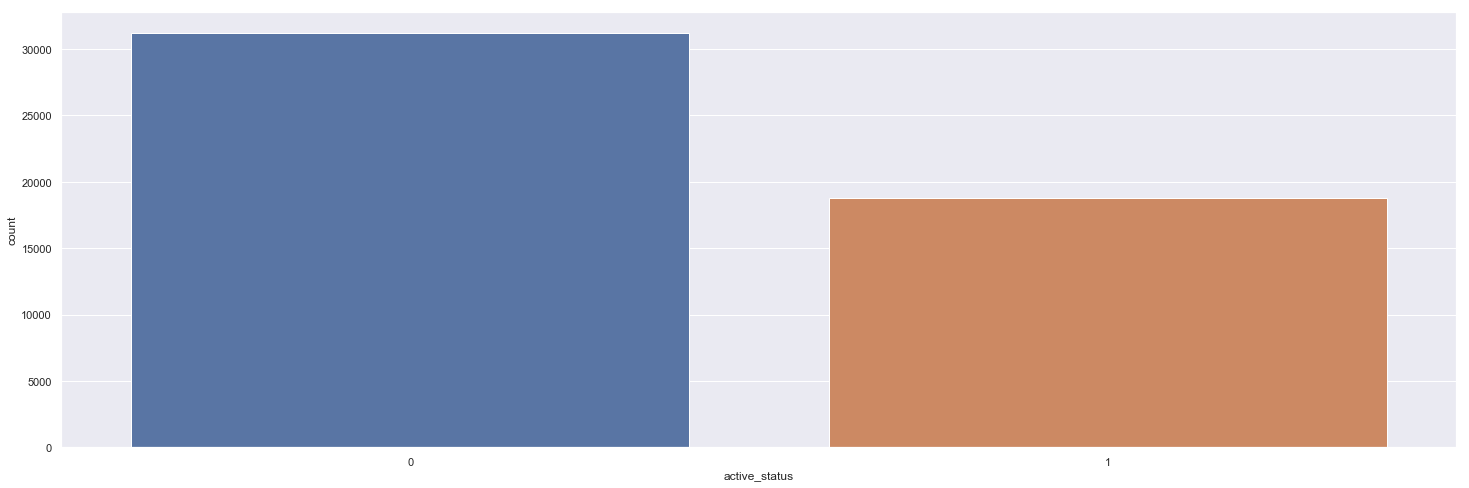

In [62]:
sns.countplot(data=df,
                  x ='active_status')

In [63]:
percent_activestatus = (df['active_status'].value_counts()/len(df['active_status'])) *100
percent_activestatus

0    62.392
1    37.608
Name: active_status, dtype: float64

**The percent retained is  37.61%**

#### Predictive Strength of each fearture on the response 'active_status':

In this section a look at the distribution of the features by group "active_status=1" and "active_status" =0 are looked at
to see is there are differences. 

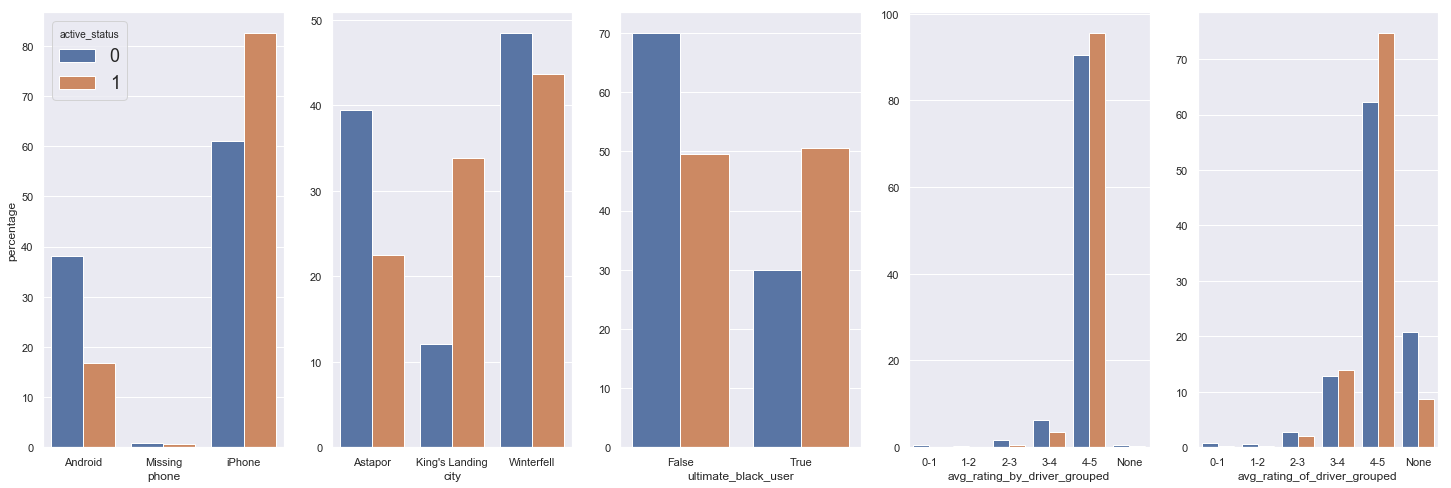

In [64]:
f, axes = plt.subplots(1, 5)

feature =['phone', 'city', 'ultimate_black_user', 'avg_rating_by_driver_grouped', 'avg_rating_of_driver_grouped']

for g, i in enumerate(feature):
    counts=(df.groupby(['active_status'])[i]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(i))
    sns.barplot(x=i, y="percentage", hue="active_status", data=counts, ax=axes[g])
    if g>0:
     axes[g].legend_.remove()
     axes[g].set_ylabel('')
    

The plots above give the percentage of users from the group that belonged to the particular category of the feature.From the above plots the following observations could be made:

1. There are more iphone users for those who were retained( active_status=1) vs more android usage for those who were not retained.
2. There were more users retained from Kings Landing as opposed to less from Astapor and Winterfell.
3. The TRUE and FAlSE proportions for ultimate black user the same for teh retained group but it differs for the group that was not retained in that there are more FALSE that TRUE. 
4. For the average rating by the driver  overall most of the scores were in the 4-5 range with the percentage of the rating scores in the 4-5 scale being  higher for the group that was retained. The percentage for the lower scores was higher for those that were not retained. 
5. For the average rating for the driver, again the higher score had a higher percentage of those that were retained.The lower ratings had a higher percentage of those that were not retained and also the no rating  was higher for those that were not retained.

Conclusion:All of the above features should be included in the model building process as they appear to have some predictive power.

Look at continous features

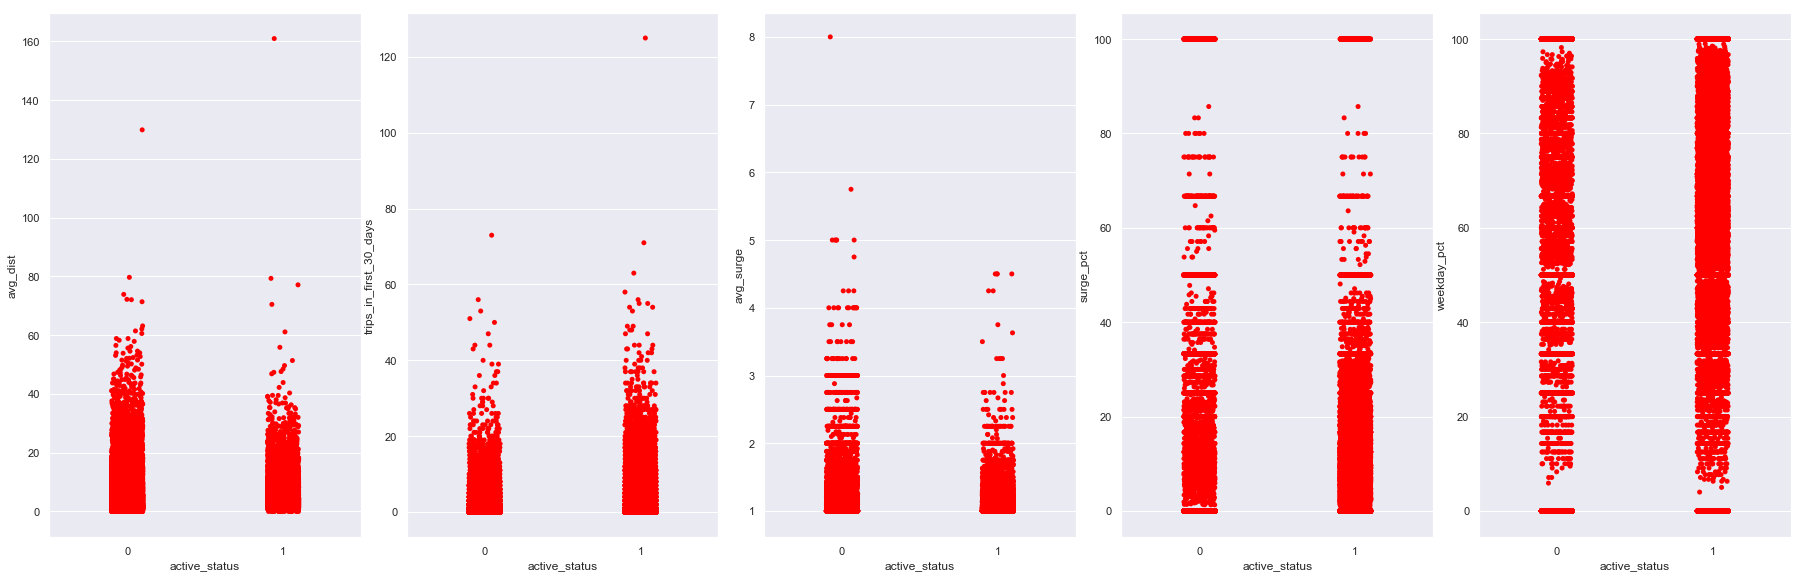

In [65]:
f, axes = plt.subplots(1, 5)
plt.tight_layout()

cols_to_plot1= ["avg_dist", "trips_in_first_30_days", "avg_surge", "surge_pct", "weekday_pct"]
            

for g, i in enumerate(cols_to_plot1):
    
      g = sns.stripplot(x="active_status", y= i, data=df,
                     size=5, jitter=True, color="red", ax=axes[g])           
                   
    

The distribution of values between the two groups are hard to distinguish. 

There are some extreme values that need to be looked at as they could be errors in the data. 

In [66]:
print(df.loc[df['avg_dist'] > 120])

       avg_dist  avg_surge            city    phone  surge_pct  \
534      129.89        1.0  King's Landing  Missing        0.0   
20701    160.96        1.0         Astapor  Android        0.0   

       trips_in_first_30_days  ultimate_black_user  weekday_pct  \
534                         0                False          0.0   
20701                       0                False        100.0   

       active_status avg_rating_by_driver_grouped avg_rating_of_driver_grouped  
534                0                          4-5                         None  
20701              1                         None                         None  


In [67]:
df.drop(index=[534, 20701], inplace=True)

Both of these entries are in error because the avg_dist is the average distance in miles per trip taken in the first 30 days after signup which is 129.86 and 160.96 but the entry for the number of trips in the first 30 days is 0. 

In [68]:
print(df.loc[df['trips_in_first_30_days'] > 115])

       avg_dist  avg_surge            city   phone  surge_pct  \
18514      2.02       1.12  King's Landing  iPhone       14.4   

       trips_in_first_30_days  ultimate_black_user  weekday_pct  \
18514                     125                 True         72.0   

       active_status avg_rating_by_driver_grouped avg_rating_of_driver_grouped  
18514              1                          4-5                          4-5  


This observation is hard to determine if it is erroneous. The user tool 125 trips in the first 30 day that averages out to about 3 trips a day which is doable if the user was using it as primary form of communication. So we will leave this observation in.

In [69]:
print(df.loc[df['avg_surge'] > 7])

       avg_dist  avg_surge        city   phone  surge_pct  \
13861      5.77        8.0  Winterfell  iPhone      100.0   

       trips_in_first_30_days  ultimate_black_user  weekday_pct  \
13861                       1                False        100.0   

       active_status avg_rating_by_driver_grouped avg_rating_of_driver_grouped  
13861              0                          4-5                          0-1  


This is a rider who has taken only one ride on January 1. The high avg_surge on Jan 1st is possible so we will keep this observation.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49998 entries, 0 to 49999
Data columns (total 11 columns):
avg_dist                        49998 non-null float64
avg_surge                       49998 non-null float64
city                            49998 non-null object
phone                           49998 non-null object
surge_pct                       49998 non-null float64
trips_in_first_30_days          49998 non-null int64
ultimate_black_user             49998 non-null bool
weekday_pct                     49998 non-null float64
active_status                   49998 non-null int64
avg_rating_by_driver_grouped    49998 non-null category
avg_rating_of_driver_grouped    49998 non-null category
dtypes: bool(1), category(2), float64(4), int64(2), object(2)
memory usage: 3.6+ MB


Create Dummies
The library “sklearn” requires features to be in numeric arrays. So convert the categorical variables into numeric variables by means of dummy coding. In creating dummy variables, a column is created corresponding to each level of the categorical feature where the value equals 1 for those observations that have that particular level and zero for all others.




In [71]:
df = pd.get_dummies(df)
df.info()   

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49998 entries, 0 to 49999
Data columns (total 25 columns):
avg_dist                             49998 non-null float64
avg_surge                            49998 non-null float64
surge_pct                            49998 non-null float64
trips_in_first_30_days               49998 non-null int64
ultimate_black_user                  49998 non-null bool
weekday_pct                          49998 non-null float64
active_status                        49998 non-null int64
city_Astapor                         49998 non-null uint8
city_King's Landing                  49998 non-null uint8
city_Winterfell                      49998 non-null uint8
phone_Android                        49998 non-null uint8
phone_Missing                        49998 non-null uint8
phone_iPhone                         49998 non-null uint8
avg_rating_by_driver_grouped_None    49998 non-null uint8
avg_rating_by_driver_grouped_0-1     49998 non-null uint8
avg_rating_by_

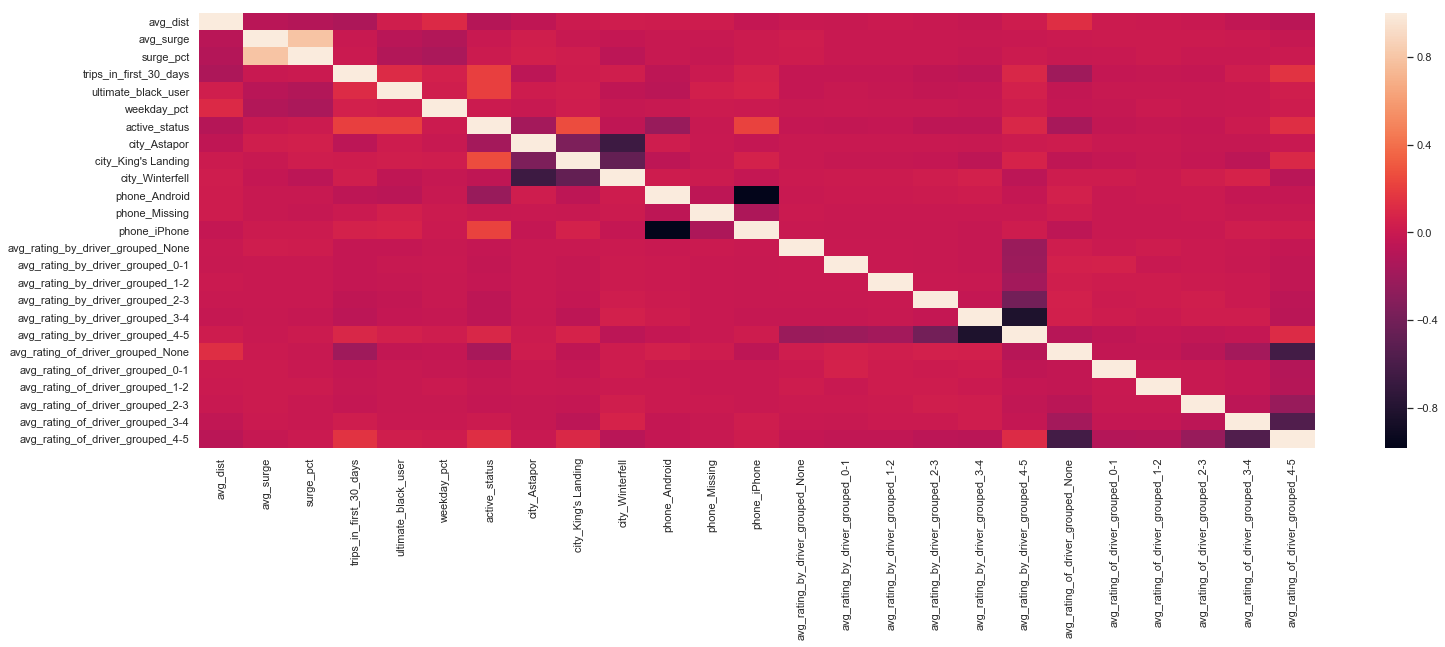

In [72]:
sns.heatmap(df.corr())

From looking at the correlations between features the only two features that are correlated are avg_surge and surge_pct. 

avg_surge is the The average surge multiplier over all of this users trips and surge_pct is the percent of trips taken with surge multiplier >1. 

We will keep surge_pct and drop avg_surge.

In [73]:
df.drop("avg_surge", axis=1, inplace=True)

### Prepare the data for Machine Learning algorithms
Now we are ready to create our X and Y variables needed for the machine learning classifiers. Here we will assign the features to X and the active_status to Y


In [74]:
X = df.drop('active_status', axis = 1)


y= df.active_status

###### Create a Test Set: use stratified sampling by outcome:
Before fitting the model we will set a proportion( 30%) of the data aside for testing. We will use Sklearns train_test_split to split the data into 70%for training ( model fitting) and 30% for testing. By setting the stratify option in train test split to y we are asking that the data be split keeping the same proportion of active_status in the test and the training data.

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.30, random_state=42)

### Build models by running machine learning algorithms on training data
Now we are ready to use the training data and fit some machine learning models. Whilst there are several possibilities of models that we could use here we will limit ourselves to assesing three of them.

Logistic Regression :This is a regression based algorithm where  by fitting the model a probability of a user being in the active category can be obtained. The model is easy to interpret.

Gradient Boosting: ensemble method based on building weak esitmators that are combined to reduce the bias of the final estimator.It is know that this method performs well but iterpretability is not easy.

Random Forest: ensemble method based on averaging decision trees.


In [83]:
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [76]:
rfc = RandomForestClassifier(n_jobs=-1,  oob_score = True, random_state=42 ) 

param_grid = { 
   'n_estimators': [100, 500, 750],
   'max_features': ['auto'],
   'min_samples_leaf': [15, 25],
   'max_depth': [ 5, 15, 20]
}



CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

print (CV_rfc.best_params_)

C:\deeplearning\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 100}


In [77]:
from sklearn.metrics import mean_squared_error


boost_clf = GradientBoostingClassifier(random_state=42)

param_grid = {
               'max_depth':[1,5,10,15],
               'n_estimators':[2,3,4,5],
               }

boost_cv = GridSearchCV(boost_clf, param_grid=param_grid, cv = 5)

boost_cv.fit(X_train, y_train)
print(boost_cv.best_params_)

{'max_depth': 10, 'n_estimators': 5}


In [78]:


logistic = LogisticRegression(random_state=42)

param_grid ={"penalty" :['l1', 'l2'], "C" : [0.01,0.1,1,10] }

log_cv = GridSearchCV(logistic, param_grid,
            cv=5, n_jobs=-1)

log_cv.fit(X_train, y_train)

print(log_cv.best_params_)
 


{'C': 10, 'penalty': 'l2'}


With the best model hyperparameters rerun the models and get evaluation metrics for the training data. The funciton run_models
will rerun the best models and give the evaluation metrics for each model.

In [79]:
def run_models(clfs_dict, X_train, y_train):
    
    clfs = clfs_dict
    
    cols = ['model', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()
    

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

       
        
        clf.fit(X_train, y_train)

        y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
        
        y_train_score = cross_val_predict(clf, X_train, y_train, cv=3, method="predict_proba")[:,1]

        

        tmp = pd.Series({
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_train, y_train_score),
                         
                         'precision_score': metrics.precision_score(y_train, y_train_pred),
                         'recall_score': metrics.recall_score(y_train, y_train_pred),
                         'f1_score': metrics.f1_score(y_train, y_train_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_train, y_train_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve')
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

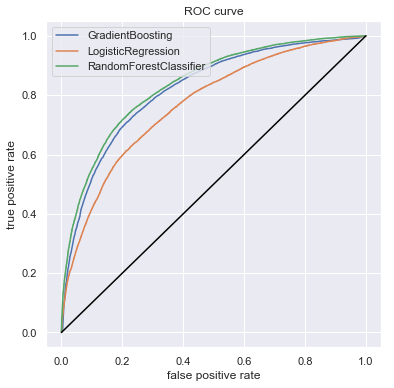

In [84]:
clfs ={'GradientBoosting': GradientBoostingClassifier(max_depth= 10, n_estimators=5, random_state=42),
            'LogisticRegression' : LogisticRegression( C=10, penalty='l2', random_state=42),   
            'RandomForestClassifier': RandomForestClassifier(random_state=42, max_depth=15, max_features="auto", 
                                                             min_samples_leaf=15, n_estimators=100, n_jobs=-1,  oob_score = True)
                                                            
            }
    
models_report, conf_matrix  = run_models(clfs, X_train, y_train)

In [85]:
models_report

,model,roc_auc_score,precision_score,recall_score,f1_score
0,GradientBoosting,0.819720,0.782305,0.450767,0.571966
1,LogisticRegression,0.768645,0.684308,0.503951,0.580442
2,RandomForestClassifier,0.836040,0.745237,0.600289,0.664955


In [86]:
conf_matrix['GradientBoosting']


Predicted,0,1
True,,
0,20185,1651
1,7229,5933


In [87]:
conf_matrix['LogisticRegression']

Predicted,0,1
True,,
0,18776,3060
1,6529,6633


In [88]:
conf_matrix['RandomForestClassifier']

Predicted,0,1
True,,
0,19135,2701
1,5261,7901


On comparing the performance of the three models based on roc_auc score, precision, recall and the f1_score which is the harmonic mean of precision and recall, the Random Forest appears to be the best option.

Feature Importance
Next we will take a closer look at the fitted model. What is the relative importance of each feature in its abiliity to sort out the the active users from the non active users. The RandomForestClassifier has an attribute called feature_importances_ which gives us the relative importance for each feature.

In [89]:
rfc_best=RandomForestClassifier(random_state=42, max_depth=15, max_features="auto", 
                                                             min_samples_leaf=15, n_estimators=100, n_jobs=-1,  oob_score = True)
rfc_best.fit(X_train, y_train)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rfc_best.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print (importances)

                                   importance
feature                                      
surge_pct                               0.210
weekday_pct                             0.196
city_King's Landing                     0.128
trips_in_first_30_days                  0.104
ultimate_black_user                     0.072
phone_Android                           0.060
phone_iPhone                            0.060
avg_dist                                0.058
city_Astapor                            0.048
city_Winterfell                         0.027
avg_rating_of_driver_grouped_None       0.014
avg_rating_of_driver_grouped_4-5        0.009
avg_rating_by_driver_grouped_4-5        0.004
avg_rating_of_driver_grouped_3-4        0.003
avg_rating_by_driver_grouped_3-4        0.002
avg_rating_by_driver_grouped_2-3        0.001
avg_rating_of_driver_grouped_2-3        0.001
avg_rating_by_driver_grouped_0-1        0.000
avg_rating_by_driver_grouped_1-2        0.000
phone_Missing                     

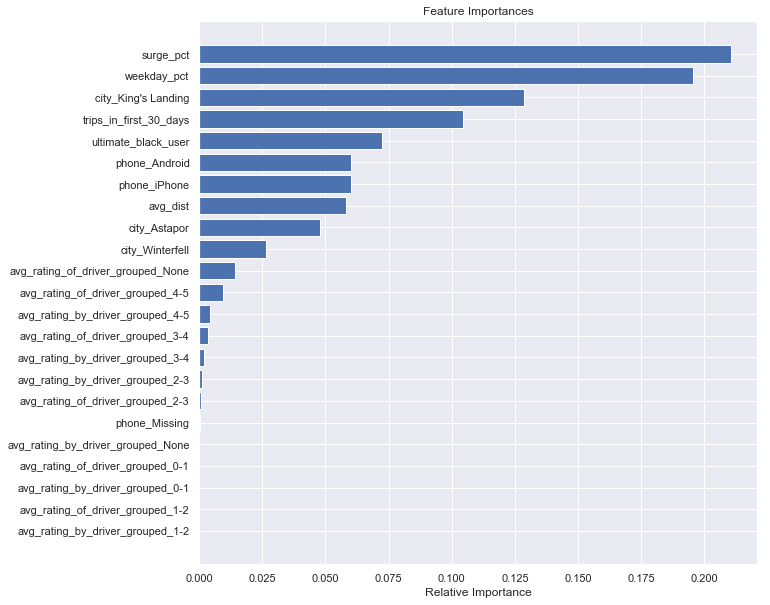

In [90]:
features = X_train.columns
importances = rfc_best.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Looking at the above feature importance the most important is surge_pct, weekday_pct, city and number of trips in first 30 days 
ultimate_black_user, phone, avg_dist account for 90.3% percent of importance in sorting out the active users from the non active users. Rerun the model dropping the average ratings.

In [101]:
cols_to_drop=["avg_rating_of_driver_grouped_None",
             "avg_rating_of_driver_grouped_4-5",      
              "avg_rating_by_driver_grouped_4-5",       
             "avg_rating_of_driver_grouped_3-4",       
             "avg_rating_by_driver_grouped_3-4" ,      
             "avg_rating_by_driver_grouped_2-3",    
            "avg_rating_of_driver_grouped_2-3",
            "avg_rating_by_driver_grouped_0-1",
            "avg_rating_by_driver_grouped_1-2",        
             "avg_rating_of_driver_grouped_0-1",       
            "avg_rating_of_driver_grouped_1-2",        
            "avg_rating_by_driver_grouped_None"   ]   


X_train.drop(cols_to_drop, axis=1, inplace=True)

C:\deeplearning\anaconda\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [102]:
rfc_best=RandomForestClassifier(random_state=42, max_depth=15, max_features="auto", 
                                                             min_samples_leaf=15, n_estimators=100, n_jobs=-1,  oob_score = True)
rfc_best.fit(X_train, y_train)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rfc_best.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print (importances)

                        importance
feature                           
weekday_pct                  0.229
surge_pct                    0.215
city_King's Landing          0.127
avg_dist                     0.103
trips_in_first_30_days       0.097
ultimate_black_user          0.073
phone_iPhone                 0.054
phone_Android                0.049
city_Astapor                 0.035
city_Winterfell              0.018
phone_Missing                0.000


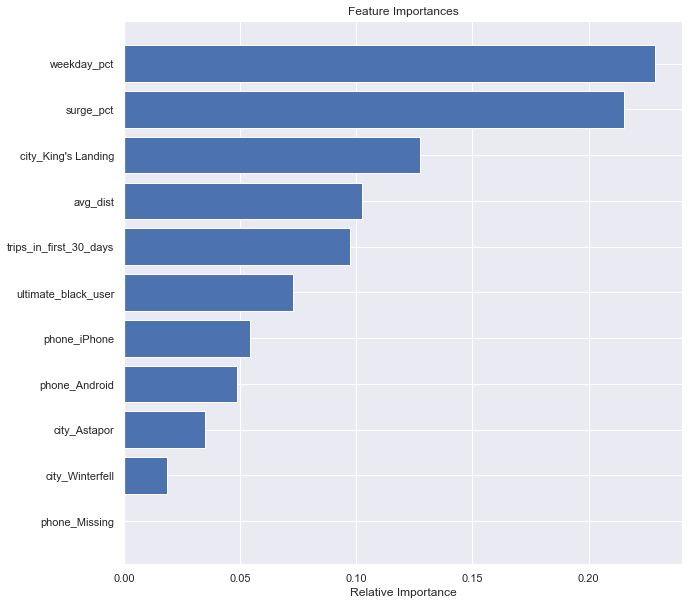

In [103]:
features = X_train.columns
importances = rfc_best.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Retune the model:


In [104]:
rfc=RandomForestClassifier(random_state=42,  n_jobs=-1,  oob_score = True)

param_grid = { 
   'n_estimators': [50, 100, 250, 500],
   'max_features': ['auto'],
   'min_samples_leaf': [10, 15, 20],
   'max_depth': [ 10 , 15, 20]
}



CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

print (CV_rfc.best_params_)

{'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 250}


In [105]:
rfc_tuned = RandomForestClassifier(n_jobs=-1, max_features= 'auto' , n_estimators=250, oob_score = True, random_state=42,
                             max_depth=15, min_samples_leaf=10 ) 
rfc_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [106]:
X_prob = rfc_tuned.predict_proba(X_train)
y_predictions = rfc_tuned.predict(X_train)

cols = ['model', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

models_report = pd.DataFrame(columns = cols)
conf_matrix = dict()

tmp = pd.Series({ 'model': "Tuned Random Forest on Training Data",
                  'roc_auc_score' : metrics.roc_auc_score(y_train,  X_prob[:,1]),
                  'precision_score': metrics.precision_score(y_train, y_predictions ),
                  'recall_score': metrics.recall_score(y_train, y_predictions),
                  'f1_score': metrics.f1_score(y_train, y_predictions)})
models_report = models_report.append(tmp, ignore_index = True)

conf_matrix = pd.crosstab(y_train, y_predictions, rownames=['True'], colnames= ['Predicted'], margins=False)

In [107]:
models_report

,model,roc_auc_score,precision_score,recall_score,f1_score
0,Tuned Random Forest on Training Data,0.884793,0.7792,0.679684,0.726048


In [108]:
conf_matrix

Predicted,0,1
True,,
0,19301,2535
1,4216,8946


In [109]:
feature_importances = rfc_tuned.feature_importances_
feature_importances

array([0.13240386, 0.20594118, 0.10295935, 0.06775321, 0.22685896,
       0.03089697, 0.11954549, 0.01830727, 0.04380374, 0.00035547,
       0.05117449])

In [110]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rfc_tuned.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print (importances)

                        importance
feature                           
weekday_pct                  0.227
surge_pct                    0.206
avg_dist                     0.132
city_King's Landing          0.120
trips_in_first_30_days       0.103
ultimate_black_user          0.068
phone_iPhone                 0.051
phone_Android                0.044
city_Astapor                 0.031
city_Winterfell              0.018
phone_Missing                0.000


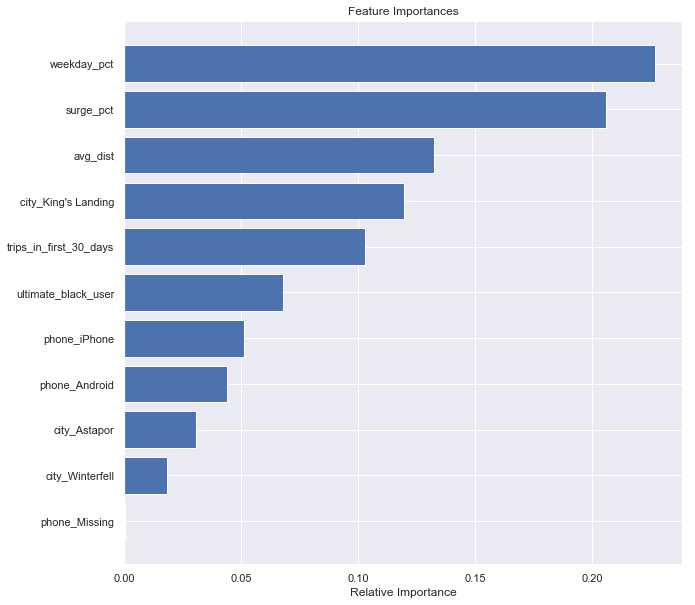

In [111]:
plt.figure(figsize=(10, 10))

features = X_train.columns
importances = rfc_tuned.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

### Evaluate model using Test set.


In [112]:
X_test =pd.DataFrame(X_test, columns=X_test.columns)

In [113]:
#keep only features that were important in the fianl model
cols_to_drop=["avg_rating_of_driver_grouped_None",
             "avg_rating_of_driver_grouped_4-5",      
              "avg_rating_by_driver_grouped_4-5",       
             "avg_rating_of_driver_grouped_3-4",       
             "avg_rating_by_driver_grouped_3-4" ,      
             "avg_rating_by_driver_grouped_2-3",    
            "avg_rating_of_driver_grouped_2-3",
            "avg_rating_by_driver_grouped_0-1",
            "avg_rating_by_driver_grouped_1-2",        
             "avg_rating_of_driver_grouped_0-1",       
            "avg_rating_of_driver_grouped_1-2",        
            "avg_rating_by_driver_grouped_None"   ]   

X_test.drop(cols_to_drop, axis=1, inplace=True)

In [114]:
final_prob = rfc_tuned.predict_proba(X_test)

In [115]:

final_predictions = rfc_tuned.predict(X_test)


In [116]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, final_predictions)

In [117]:
cols = ['model', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

models_report = pd.DataFrame(columns = cols)
conf_matrix = dict()

tmp = pd.Series({ 'model': "Random Forest on Test Data",
                  'roc_auc_score' : metrics.roc_auc_score(y_test, final_prob[:,1]),
                  'precision_score': metrics.precision_score(y_test, final_predictions),
                  'recall_score': metrics.recall_score(y_test, final_predictions),
                  'f1_score': metrics.f1_score(y_test, final_predictions)})
models_report = models_report.append(tmp, ignore_index = True)

conf_matrix = pd.crosstab(y_test, final_predictions, rownames=['True'], colnames= ['Predicted'], margins=False)

In [118]:
models_report


,model,roc_auc_score,precision_score,recall_score,f1_score
0,Random Forest on Test Data,0.842795,0.731104,0.639603,0.6823


In [119]:
conf_matrix

Predicted,0,1
True,,
0,8032,1327
1,2033,3608


On using the Random Forest model to predict the outcome for the loans on the test data the Roc_Auc Score dropped from 88% to 84%. The precision, recall and F1 scores also dropped. This drop in scores from the training to the test indicate model overfitting. Model overfitting is where the model does not generalize well to unseen data indicating that the model is including residual variation particular to the training data as part of the model. However this drop is not huge so the model has potential.


Someways in which we could address this:
We did not address the imbalance in the proportions retained vs not retained. Rerun addressing the imbalance. One way is to use SMOTE or give a higher weight to the class that is underrepresented.
This would reduce the False Negatives. 
It is possible that there are features that have a bigger impact that is not present in the dataset. Include other features that may be relevant.
The Gradient Boost models may have room for improvement. 

### Conclusion:

Based on the data 37% of the users were retained. The model fitted indicated the following factors to be most influential.

The percent of the users trips occuring during the weekday and the percent of trips taken with a surge multiplier >1  being the top two most influential predictors in determining if a user would be retained or not.





